# Latency Comparison

In this section we collect results from measuring the latency between ingesting data from the source and collecting the data from the broker (i.e., Kafka vs NGSI-LD Broker).

## Building datasets


### Scorpio

In [131]:
import pandas as pd

Disable scientific notation in datasets

In [251]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [252]:
events = [10,20,50,70,100]

In [253]:
import glob

scorpio = []
for event in events:
    path = r'./results/scorpio/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    scorpio.append(pd.concat(li, axis=0, ignore_index=True))

Estimate the delta between the capture and notification timestamps

In [254]:
scorpio_means = []
for table in scorpio:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["captureTimestamp"]
    scorpio_means.append(table["deltaTimestamp"].mean())

### Kafka

In [255]:
import glob

kafka = []
for event in events:
    path = r'./results/kafka/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    kafka.append(pd.concat(li, axis=0, ignore_index=True))

In [256]:
kafka_means = []
for table in kafka:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["captureTimestamp"]
    kafka_means.append(table["deltaTimestamp"].mean())

## Visualization

Once the datasets haven prepared, move on to creating some plots.

In [257]:
import matplotlib.pyplot as plt
plt.close("all")

In [258]:
latency = pd.DataFrame({"Events": events,"Scorpio": scorpio_means, 
                        "Kafka": kafka_means })

<AxesSubplot:xlabel='Events'>

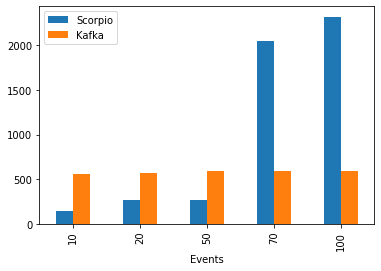

In [259]:
latency.plot.bar(x="Events")

# Container Performance

The following snippet produces docker stats and appends the results to a CSV file:

```bash
while true; do docker stats <my_container> --no-stream --format "{{ .MemPerc }},{{ .CPUPerc }}" | tee --append stats.csv; sleep 1; done
```

## Building the Datasets

Process the generated CSV files using panda. First remove the percentage character from the memory and CPU columns. Generate two charts - memory and CPU - that compare Kafka container against each NGSI-LD Broker container.

In [293]:
scorpio_container_70 = pd.read_csv("results_containers/scorpio_70.csv", index_col=None, header=0, names=["scorpio","memory", "cpu"])

In [294]:
scorpio_memory_70 = scorpio_container_70['memory'].str.rstrip('%').astype('float') / 100.0
scorpio_cpu_70 = scorpio_container_70['cpu'].str.rstrip('%').astype('float') / 100.0

In [302]:
scorpio_memory_70_mean = scorpio_memory_70.mean()

## Visualization

In [304]:
containers = pd.DataFrame({"Events": [70],"Scorpio": [scorpio_memory_70_mean]})

In [305]:
containers

,Events,Scorpio
0,70,0.227


<AxesSubplot:xlabel='Events'>

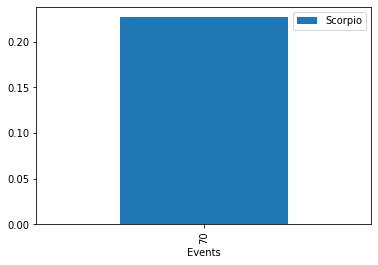

In [306]:
containers.plot.bar(x="Events")